In [1]:
import datetime
import pandas as pd
import glob
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
from sklearn.preprocessing import normalize
from sqlalchemy import create_engine
from helper_functions import load_data, get_data4uid

# Data Analysis

If you didn't load the raw data from [Tankerkoenig](https://dev.azure.com/tankerkoenig/_git/tankerkoenig-data) you can start here with loading the data from sqllite database.
Here i will have a look at some interesting points out of the data.

In [2]:
# run this cell to load data from sql file
prices_pd, stations_pd = load_data('./Data/prices_40.sql')

In [4]:
prices_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2677793 entries, 0 to 2677792
Data columns (total 5 columns):
date            datetime64[ns]
station_uuid    object
diesel          float64
e5              float64
e10             float64
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 102.1+ MB


In [5]:
# make uuid as category
prices_pd.station_uuid = prices_pd.station_uuid.astype('category')

In [6]:
prices_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2677793 entries, 0 to 2677792
Data columns (total 5 columns):
date            datetime64[ns]
station_uuid    category
diesel          float64
e5              float64
e10             float64
dtypes: category(1), datetime64[ns](1), float64(3)
memory usage: 86.8 MB


In [7]:
prices_pd.isnull().values.any()

True

So we have now all prices and stations to have a closer look, how the prices are raising and decreasing. As we see from cell above, we have NaN values insight our data. I will leave it here and drop it later for the specific data if it is necessary.

In [8]:
# how does the data look like for one station
prices_pd[prices_pd['station_uuid'] == '005056ba-7cb6-1ed2-bceb-82ea369c0d2d']

date                          station_uuid  diesel  \
133     2015-01-01 08:50:01  005056ba-7cb6-1ed2-bceb-82ea369c0d2d   1.189   
184     2015-01-01 10:22:01  005056ba-7cb6-1ed2-bceb-82ea369c0d2d   1.189   
253     2015-01-01 11:34:01  005056ba-7cb6-1ed2-bceb-82ea369c0d2d   1.169   
307     2015-01-01 12:26:01  005056ba-7cb6-1ed2-bceb-82ea369c0d2d   1.119   
358     2015-01-01 13:54:01  005056ba-7cb6-1ed2-bceb-82ea369c0d2d   1.099   
...                     ...                                   ...     ...   
2677289 2019-12-20 16:47:04  005056ba-7cb6-1ed2-bceb-82ea369c0d2d   1.249   
2677399 2019-12-20 17:27:03  005056ba-7cb6-1ed2-bceb-82ea369c0d2d   1.239   
2677465 2019-12-20 17:57:04  005056ba-7cb6-1ed2-bceb-82ea369c0d2d   1.229   
2677661 2019-12-20 20:27:04  005056ba-7cb6-1ed2-bceb-82ea369c0d2d   1.229   
2677782 2019-12-20 22:03:03  005056ba-7cb6-1ed2-bceb-82ea369c0d2d   1.259   

            e5    e10  
133      1.339  1.299  
184      1.329  1.289  
253      1.309  1.269  
307      1.279  1.239  
358      1.259  1.219  
...        ...    ...  
2677289  1.379  1.359  
2677399  1.369  1.349  
2677465  1.359  1.339  
2677661  1.349  1.329  
2677782  1.379  1.359  

[22543 rows x 5 columns]

In [9]:
# get data for one station and type "diesel"
star_bahn = get_data4uid(prices_pd, '005056ba-7cb6-1ed2-bceb-82ea369c0d2d', 'diesel')

In [10]:
star_bahn.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22543 entries, 2015-01-01 08:50:01+00:00 to 2019-12-20 22:03:03+00:00
Data columns (total 1 columns):
diesel    22218 non-null float64
dtypes: float64(1)
memory usage: 352.2 KB


In [11]:
star_bahn.head()

diesel
date                             
2015-01-01 08:50:01+00:00   1.189
2015-01-01 10:22:01+00:00   1.189
2015-01-01 11:34:01+00:00   1.169
2015-01-01 12:26:01+00:00   1.119
2015-01-01 13:54:01+00:00   1.099

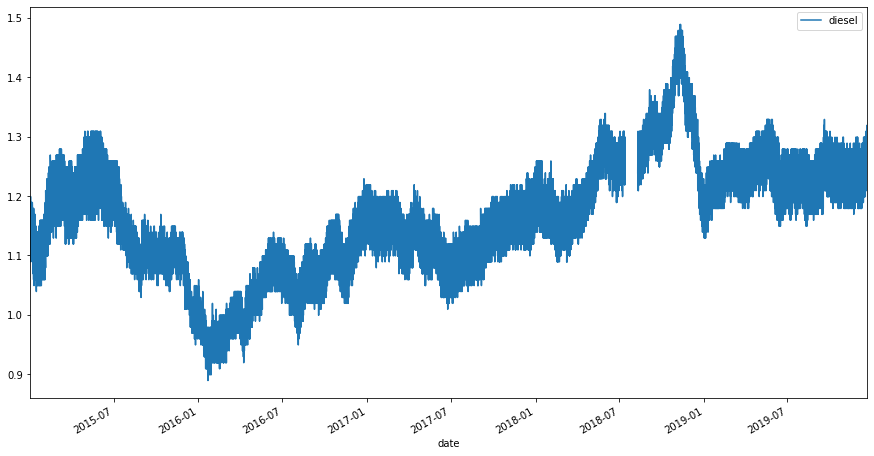

In [12]:
#let's have a look at the data
star_bahn.plot(figsize=(15,8));

In [13]:
# get samples per day
star_day = star_bahn.resample('d').mean()

In [14]:
# now remove the np.nan values
star_day.dropna(inplace=True)

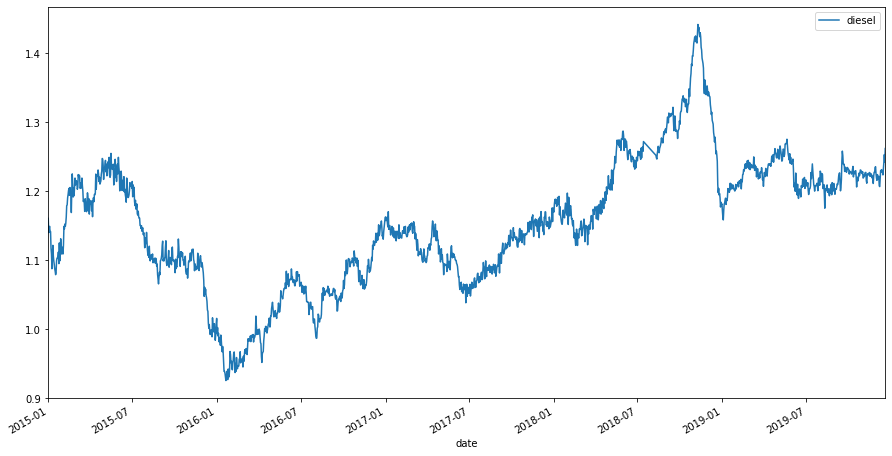

In [15]:
star_day.plot(figsize=(15,8));

In [16]:
star_day.isna().sum()

diesel    0
dtype: int64

So we have no np.nan anymore in our dataset, but we have a few day in 2018 without data. Possible the station was closed in this time. I'll think this should not be a problem.

In [17]:
# get another station
total = get_data4uid(prices_pd, '79fb1f24-bebb-489e-841f-728f9053b555', 'diesel')

In [18]:
total_day = total.resample('d').mean()

In [19]:
total_day.diesel.idxmax()

Timestamp('2018-11-09 00:00:00+0000', tz='UTC', freq='D')

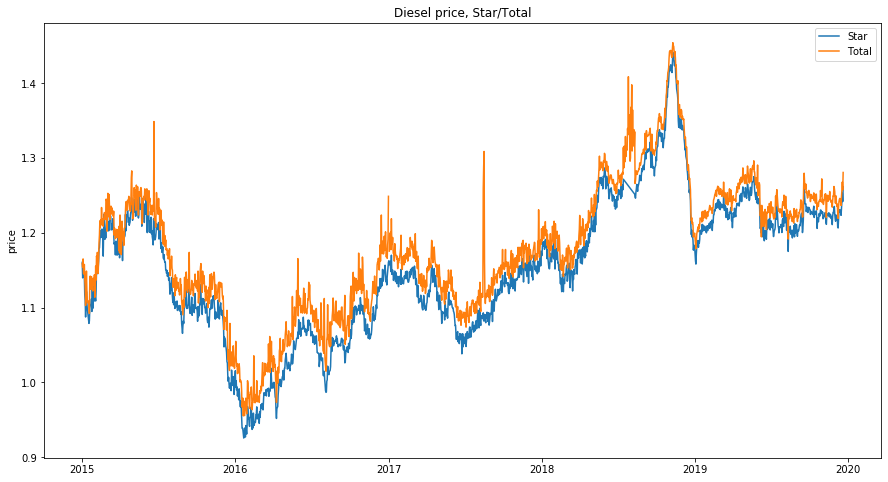

In [20]:
# plot both stations in one plot to see 
plt.figure(figsize=(15,8));
plt.plot(star_day, label = 'Star');
plt.plot(total_day, label = 'Total');
plt.title('Diesel price, Star/Total')
plt.ylabel('price')
plt.legend();

### Wrong data?
The price of Total diesel price somewhre between july/august of 2017 is one crazy peak. Let's have a closer look...

In [21]:
total_day['2017-07':'2017-08'].diesel.idxmax()

Timestamp('2017-08-16 00:00:00+0000', tz='UTC', freq='D')

In [22]:
total_day['2017-08-12':'2017-08-18'].diesel

date
2017-08-12 00:00:00+00:00    1.114000
2017-08-13 00:00:00+00:00    1.114556
2017-08-14 00:00:00+00:00    1.259000
2017-08-15 00:00:00+00:00    1.289000
2017-08-16 00:00:00+00:00    1.309000
2017-08-17 00:00:00+00:00    1.161500
2017-08-18 00:00:00+00:00    1.115667
Freq: D, Name: diesel, dtype: float64

In [23]:
total['2017-08-13':'2017-08-17'].diesel

date
2017-08-13 06:27:05+00:00    1.189
2017-08-13 07:17:05+00:00    1.089
2017-08-13 08:57:06+00:00    1.089
2017-08-13 09:47:07+00:00    1.069
2017-08-13 10:27:05+00:00    1.099
2017-08-13 15:12:06+00:00    1.119
2017-08-13 16:27:05+00:00    1.089
2017-08-13 18:27:06+00:00    1.069
2017-08-13 19:57:06+00:00    1.219
2017-08-14 10:28:06+00:00    1.249
2017-08-14 15:12:07+00:00    1.269
2017-08-15 15:12:06+00:00    1.289
2017-08-16 15:12:06+00:00    1.309
2017-08-17 07:17:05+00:00    1.109
2017-08-17 10:27:06+00:00    1.139
2017-08-17 15:12:09+00:00    1.159
2017-08-17 19:57:07+00:00    1.239
Name: diesel, dtype: float64

The data seems to be valid, it could be that some dataset is missing and therefore the step is so big. On 14th there are only two values and on 15+16th of august there is only one value. It is a little bit strange, but it can be.

In [24]:
# want to see the differences from day to day
star_day_diff = star_day.diff()
total_day_diff = total_day.diff()

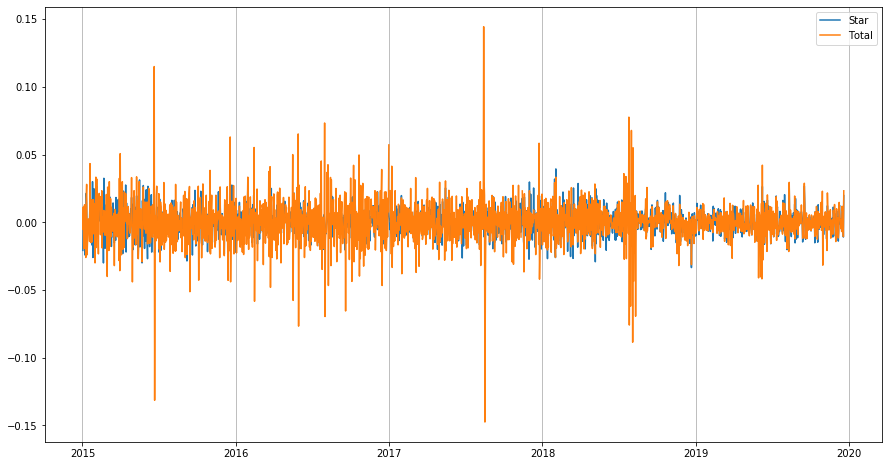

In [25]:
plt.figure(figsize=(15,8))
plt.plot(star_day_diff)
plt.plot(total_day_diff)
plt.grid(axis='x')
plt.legend(['Star', 'Total']);

#### Many differences...
between days, but now let's have a closer look in a shorter time frame and the corresponding prices.
The two choosen stations are in same location around 500 m distance.

In [26]:
star_intraday = star_bahn['2017-05-01':'2017-05-07']

In [27]:
total_intraday = total['2017-05-01':'2017-05-07']

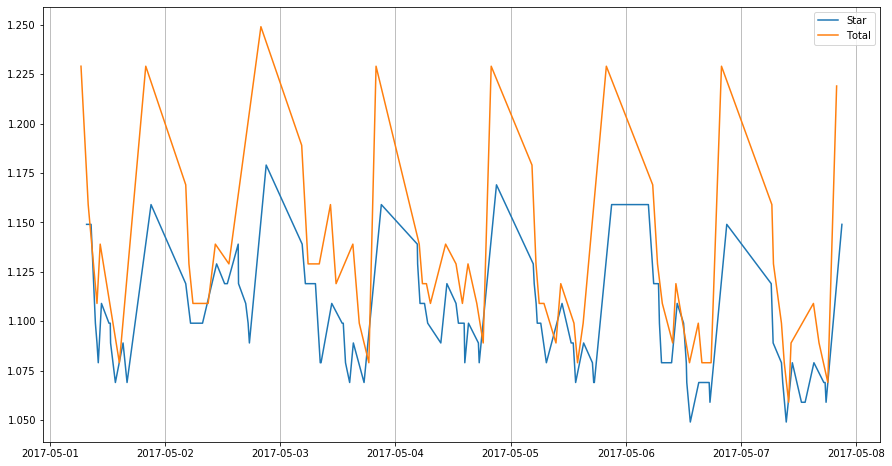

In [28]:
plt.figure(figsize=(15,8))
plt.plot(star_intraday)
plt.plot(total_intraday)
plt.grid(axis='x')
plt.legend(['Star', 'Total']);

#### Findings
In the plot above you can easily find who follows whom: The Total is raising the price first and Star is following. In price reduction Star is first and Total follows. Interesting :-)

#### Daily highs and lows
How does it look during a day? When is the lowest price on a day, when is the highest in the mean over all days? 
Therefore I make a function to plot the data.

In [29]:
def plot_day4uuid(uuid, typ='diesel', name=None, save=None):
    '''
    plots a distribution of prices on a day based on last year and for 2019
    Input: 
    uuid : id of station
    typ : which type of gas 
    name : Title for the plot
    save : filename to save'''
    hourly_ticks = 60 * 60 * np.arange(24)
    data = get_data4uid(prices_pd, uuid, typ)
    # drop wrong data
    data.drop(data[data[typ] < 0.5].index, inplace=True)
    data.dropna(inplace=True)
    
    # resample to hourly values
    data_h = data.resample('H').mean().dropna()
    # groupby hour for all data 
    data_byday = data_h.groupby(data_h.index.time).mean()
    # groupby hour only for 2019
    data_2019 = data_h['2019-01-01':]
    data_byday_2019 = data_2019.groupby(data_2019.index.time).mean()
    
    plt.figure(figsize=(15,8))
    plt.plot(data_byday, label='Hourly Mean')
    plt.plot(data_byday_2019, label='Hourly Mean 2019')
    if name:
        plt.title(name)
    else:
        plt.title(uuid)
    plt.legend()
    plt.xticks(hourly_ticks)
    if save:
        plt.savefig(save)


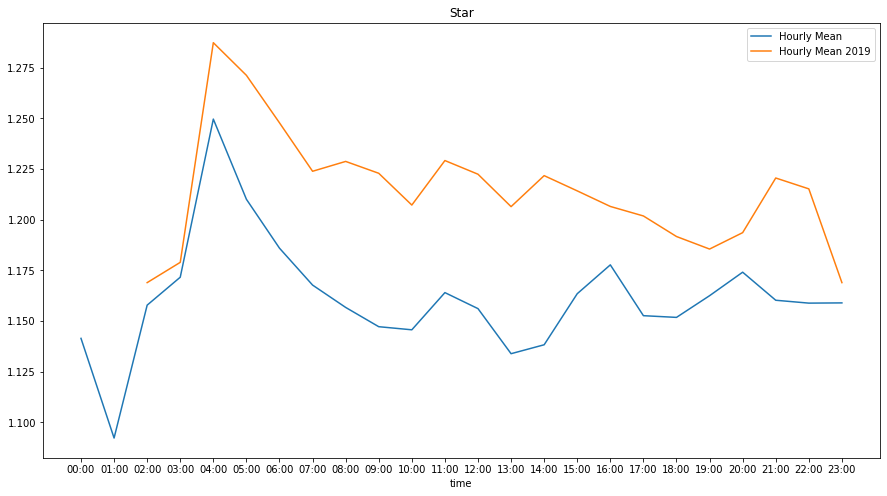

In [30]:
plot_day4uuid('005056ba-7cb6-1ed2-bceb-82ea369c0d2d', 'diesel', 'Star', save='./star_hourly_mean.png')

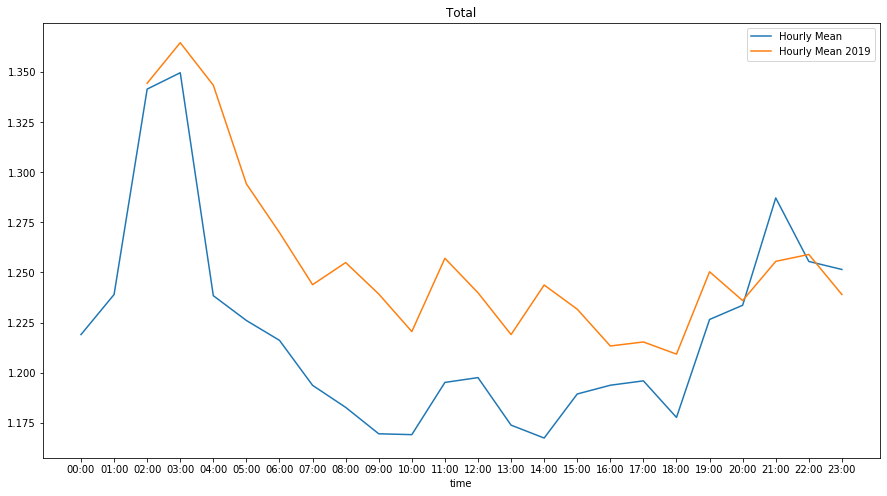

In [31]:
plot_day4uuid('79fb1f24-bebb-489e-841f-728f9053b555', 'diesel', 'Total')

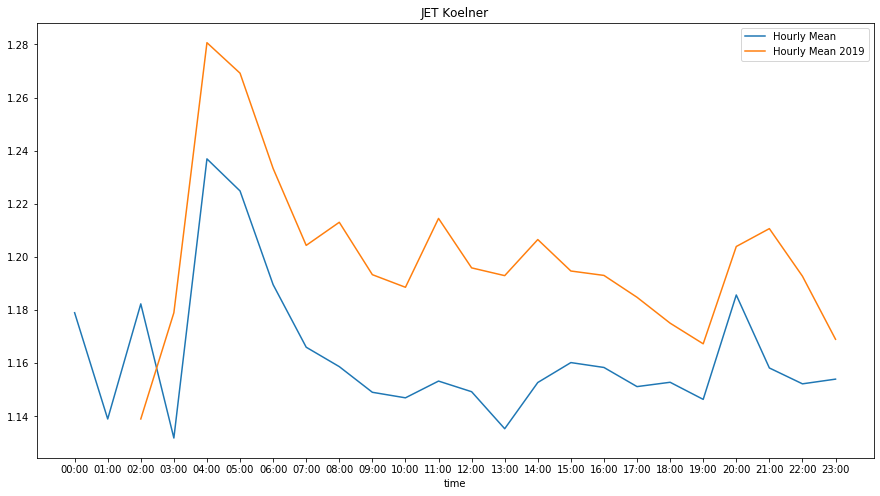

In [32]:
plot_day4uuid('51d4b59c-a095-1aa0-e100-80009459e03a', name='JET Koelner', save='./jetkoelner.png')

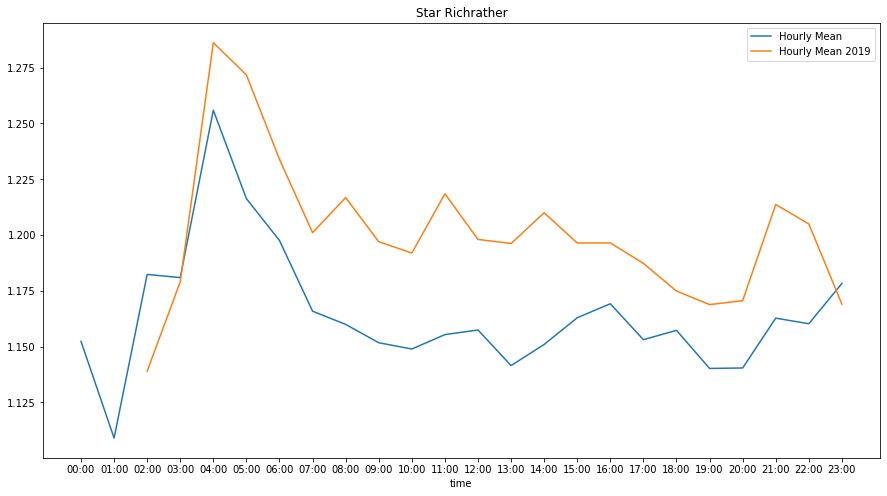

In [33]:
plot_day4uuid('005056ba-7cb6-1ed2-bceb-a46e32000d3e', name='Star Richrather', save='./starrichrather.png')

In [34]:
star_bahn.describe()

diesel
count  22218.000000
mean       1.171140
std        0.093704
min        0.889000
25%        1.109000
50%        1.179000
75%        1.229000
max        1.489000

#### Good Time, good price
It seems in the examples above that in average it is a good to get fuel in the evening, depending on your preferred station beween 18-19 o'clock (Star) or 16-19 o'clock (Total). The standard deviation is 9 cent, so it can be money saving to get fuel at the right time.

#### Price depending on weekday?
To answer this question i grouped the data by hour and weekday.

In [35]:
def plot_weekday4uuid(uuid, typ='diesel', name=None, save=None):
    '''
    plots a distribution of prices for weekday based on last years and for 2019
    Input: 
    uuid : id of station
    typ : which type of gas 
    name : Title for the plot
    save : filename to save'''
    hourly_ticks = np.arange(25)
    data = get_data4uid(prices_pd, uuid, typ)
    # drop wrong data
    data.dropna(inplace=True)
    
    # resample to hourly values
    data = data.resample('H').mean().dropna()
    
    # groupby hour only for 2019
    data_2019 = data['2019-01-01':].copy()
    
    data['day'] = data.index.weekday
    data['hour'] = data.index.hour
    data_2019['day'] = data_2019.index.weekday
    data_2019['hour'] = data_2019.index.hour

    
    fig, [ax, ax2] = plt.subplots(2, 1, figsize=(15,12), constrained_layout=True)
    
    data.groupby(['hour','day']).mean()['diesel'].unstack().plot(ax=ax)
    data_2019.groupby(['hour','day']).mean()['diesel'].unstack().plot(ax=ax2)

    if name:
        ax.set_title(name)
        ax2.set_title(name+' 2019')
    else:
        ax.set_title(uuid)
        ax.set_title(uuid+' 2019')

    #ax.legend()
    ax.set_xticks(hourly_ticks)
    ax2.set_xticks(hourly_ticks)
    #ax.set_xlim(6,23)
    #ax2.set_xlim(6,23)
    fig.suptitle('Hourly prices grouped on weekdays', fontsize=16)
    if save:
        fig.savefig(save)

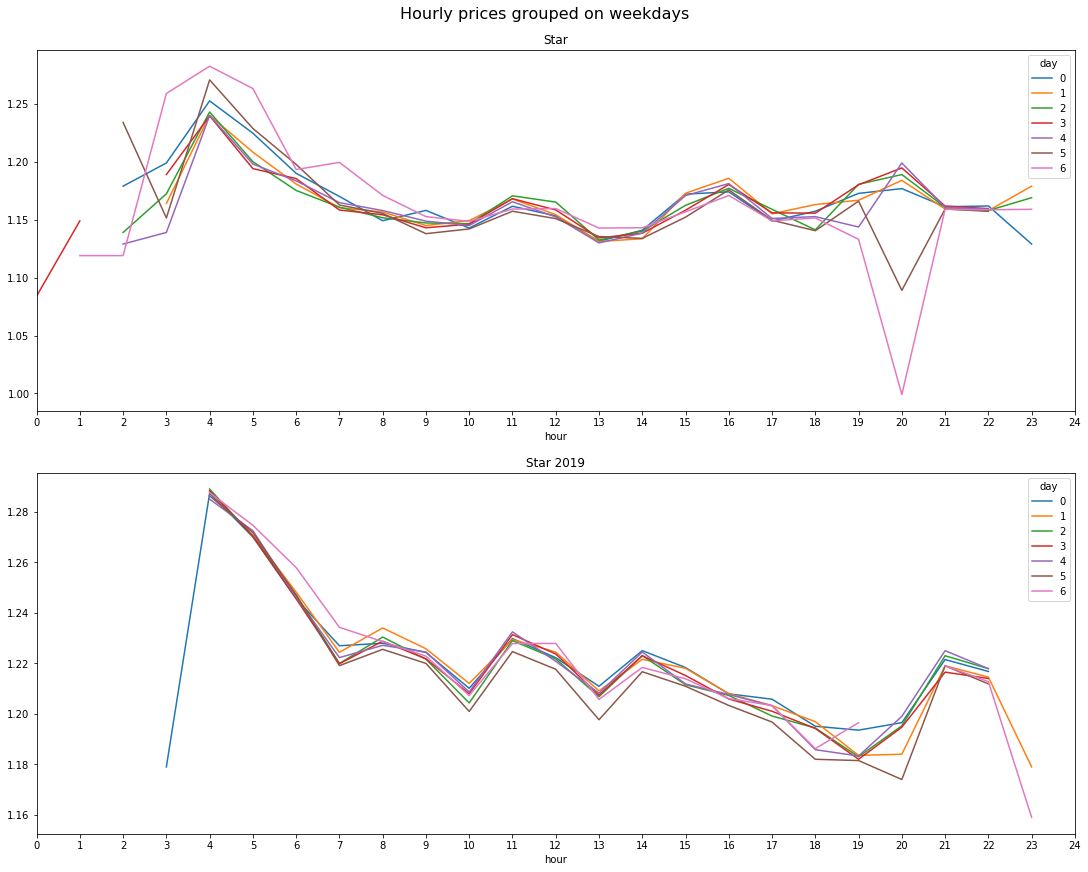

In [36]:
plot_weekday4uuid('005056ba-7cb6-1ed2-bceb-82ea369c0d2d', 'diesel', 'Star', './hourly_based_weekdays.png')

Here we have a big difference in the years before 2019, there was Saturday and Sunday at 8 pm a obvious lowest price. In 2019 this is not more noticeable on Sundays but on Saturday it seems to be still the best time for cheapest prices.

### Statistics

Now let's see some statistics from all stations in this area and make a nice plot of it with plotly.

In [37]:
prices_pd

date                          station_uuid  diesel  \
0       2014-12-31 23:14:01  008baabd-1a5d-4b88-a10e-6b4515dc0331   1.269   
1       2014-12-31 23:38:01  1fe898c5-3a58-4660-aa86-eab4c751a041   1.189   
2       2015-01-01 00:02:01  2211d99b-c1c3-4316-bcff-a38eb5f0135f   1.279   
3       2015-01-01 03:02:01  44afad52-0417-459c-9951-8ba9457c2092   1.239   
4       2015-01-01 03:02:01  529b7b56-0ff8-4f37-b116-d3b0144bf207   1.239   
...                     ...                                   ...     ...   
2677788 2019-12-20 22:09:04  c46c827b-be21-4444-bb79-930ccc3696c8   1.269   
2677789 2019-12-20 22:13:04  008baabd-1a5d-4b88-a10e-6b4515dc0331   1.279   
2677790 2019-12-20 22:17:04  5bf85d09-ea6b-4146-b23f-4b902e2e1554   1.259   
2677791 2019-12-20 22:31:04  ee34d5a4-be1a-2a3a-e040-0b0a3dfe5d3f   1.229   
2677792 2019-12-20 22:33:04  fa055334-b7bc-4773-9f8a-01c52a9002be   1.219   

            e5    e10  
0        1.389  1.349  
1        1.329  1.289  
2        1.399  1.379  
3        1.379  1.359  
4        1.379  1.359  
...        ...    ...  
2677788  1.399  1.379  
2677789  1.419  1.399  
2677790  1.379  1.359  
2677791  1.359  1.339  
2677792  1.349  1.329  

[2677793 rows x 5 columns]

In [38]:
prices_pd.diesel.dropna(inplace=True)

In [39]:
# group on station_uuid and have a look at "diesel"
grouped = prices_pd.groupby('station_uuid')[['diesel']]

In [40]:
grouped.describe()

diesel                             \
                                        count      mean       std    min   
station_uuid                                                               
00041414-208c-4444-8888-acdc00000414   1135.0  1.181035  0.094727  0.899   
005056ba-7cb6-1ed2-bceb-7e82e4910d2a  18491.0  1.163297  0.096494  0.889   
005056ba-7cb6-1ed2-bceb-7ef561844d2a  21170.0  1.169248  0.093820  0.889   
005056ba-7cb6-1ed2-bceb-7f34524ccd2a  20989.0  1.170980  0.093268  0.889   
005056ba-7cb6-1ed2-bceb-80c585ca6d2b  18347.0  1.162966  0.096737  0.889   
...                                       ...       ...       ...    ...   
fbcdf8a7-b6ba-4ec3-ac4c-dde2f0f29934  23592.0  1.171698  0.095613  0.889   
fcdaddc5-7dc1-49f9-8286-71e8664f9e17  18273.0  1.210686  0.093774  0.909   
fd99c048-3b6b-4943-8b93-838daefba76b  28228.0  1.206852  0.099379  0.909   
fdc30c82-9cdf-4fd9-a000-bc2bfe0fc7bf   8194.0  1.121203  0.078352  0.919   
ff55d404-3609-48b2-b16a-ef4a9f2008a0  16097.0  1.172050  0.094368  0.889   

                                                                  
                                        25%    50%    75%    max  
station_uuid                                                      
00041414-208c-4444-8888-acdc00000414  1.109  1.189  1.234  1.509  
005056ba-7cb6-1ed2-bceb-7e82e4910d2a  1.099  1.169  1.229  2.458  
005056ba-7cb6-1ed2-bceb-7ef561844d2a  1.109  1.179  1.229  1.489  
005056ba-7cb6-1ed2-bceb-7f34524ccd2a  1.109  1.179  1.229  1.499  
005056ba-7cb6-1ed2-bceb-80c585ca6d2b  1.099  1.169  1.229  1.489  
...                                     ...    ...    ...    ...  
fbcdf8a7-b6ba-4ec3-ac4c-dde2f0f29934  1.109  1.179  1.239  1.479  
fcdaddc5-7dc1-49f9-8286-71e8664f9e17  1.149  1.219  1.269  1.569  
fd99c048-3b6b-4943-8b93-838daefba76b  1.139  1.219  1.269  1.509  
fdc30c82-9cdf-4fd9-a000-bc2bfe0fc7bf  1.069  1.119  1.169  1.379  
ff55d404-3609-48b2-b16a-ef4a9f2008a0  1.109  1.179  1.229  1.489  

[132 rows x 8 columns]

In [41]:
# calculate some statistical values
var_price = grouped.var()
min_price = grouped.min()
std_price = grouped.std()
var_price.rename(inplace=True, columns={"diesel":"var"})
min_price.rename(inplace=True, columns={"diesel":"min"})
std_price.rename(inplace=True, columns={"diesel":"std"})


In [42]:
short_pd = stations_pd.copy()
short_pd.set_index(['uuid'], inplace=True)

In [43]:

short_pd = short_pd.join(var_price)
short_pd = short_pd.join(min_price)
short_pd = short_pd.join(std_price)

In [44]:
short_pd.dropna(inplace=True, subset=['var', 'min', 'std'])

In [45]:
short_pd.info()

<class 'pandas.core.frame.DataFrame'>
Index: 132 entries, b63d9d27-e74f-4c6e-8dfe-aa7784bba6f7 to b253485f-535c-4554-ba4e-9c2c7093b8cc
Data columns (total 13 columns):
name                 132 non-null object
brand                124 non-null object
street               132 non-null object
house_number         87 non-null object
post_code            132 non-null object
city                 132 non-null object
latitude             132 non-null float64
longitude            132 non-null float64
first_active         132 non-null object
openingtimes_json    132 non-null object
var                  132 non-null float64
min                  132 non-null float64
std                  132 non-null float64
dtypes: float64(5), object(8)
memory usage: 14.4+ KB


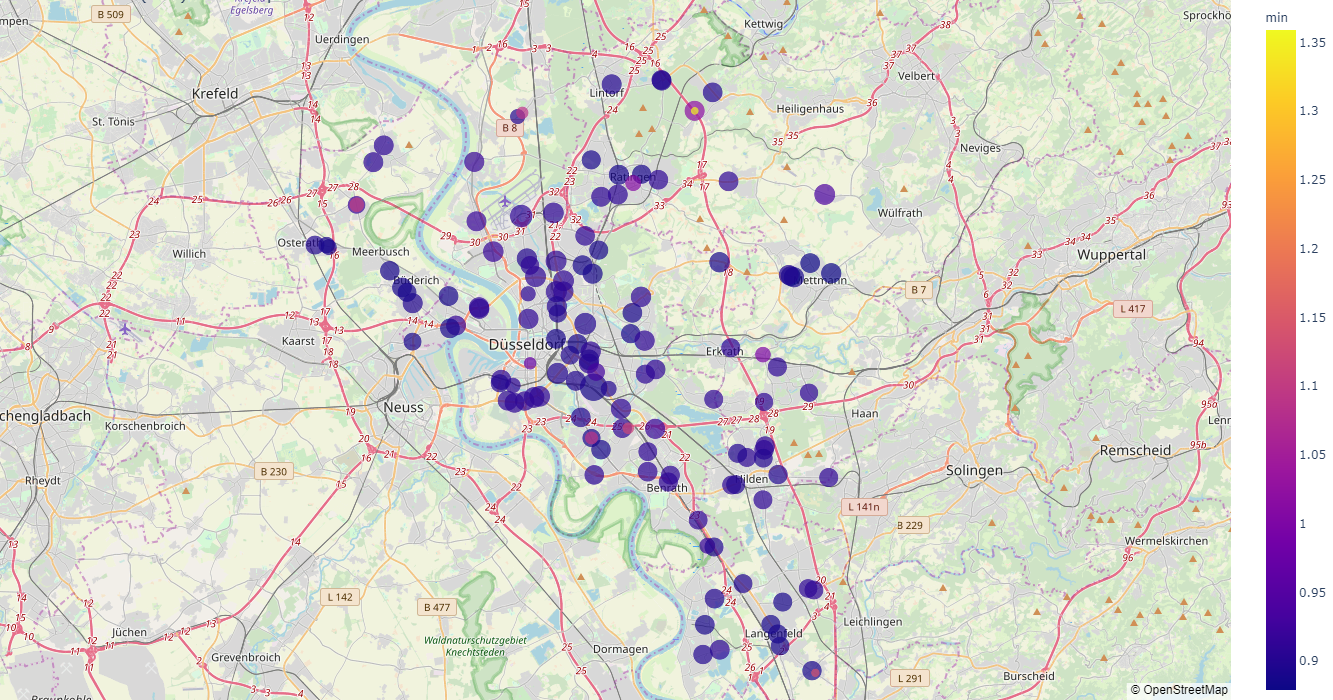

In [46]:
fig = px.scatter_mapbox(short_pd, lat="latitude", lon="longitude", hover_name="name", hover_data=["city", "post_code"],
                        color_discrete_sequence=["fuchsia"], zoom=10, width=700, height=700, size="var", color="min", title="Variance(size) and Min price")
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()